I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [18]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [ ]:
%%time
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

df = (pl.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv")
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

In [ ]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

NUMS = [ 
    'page', 
    'room_coor_x', 
    'room_coor_y', 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [ ]:
print('df1 elapsed_time 결측값 : ', pd.isnull(df1['elapsed_time']).sum())
print('df1 index 결측값 : ', pd.isnull(df1['index']).sum())
print('df2 elapsed_time 결측값 : ', pd.isnull(df2['elapsed_time']).sum())
print('df2 index 결측값 : ', pd.isnull(df2['index']).sum())
print('df3 elapsed_time 결측값 : ', pd.isnull(df3['elapsed_time']).sum())
print('df3 index 결측값 : ', pd.isnull(df3['index']).sum())

In [ ]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in name_feature],
    ]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='logbook'))|(pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='logbook'))|(pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
                
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='businesscards'))|(pl.col("fqid")=="businesscards.card_bingo.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("bisinesscards_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='businesscards'))|(pl.col("fqid")=="businesscards.card_bingo.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("bisinesscards_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")|(pl.col("fqid")=="journals_flag.pic_1.bingo")|(pl.col("fqid")=="journals_flag.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")|(pl.col("fqid")=="journals_flag.pic_1.bingo")|(pl.col("fqid")=="journals_flag.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [ ]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print('df1 done')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print('df2 done')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print('df3 done')

Unwrapped panic from Python code 에러발생 - TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'', src/apply/series.rs:219:19  
아무래도 filter에서 데이터를 더 추가하니 NaN 값이 있어 max-min 할 때, 발생하는 오류입니다.   
대처법으로는...

1. NaN 값들 다 0으로 변환
2. 데이터들을 살펴보며 NaN이 있는 데이터 추가를 하지 않기

- bisinesscards에서 에러가 발생했습니다.
- bisinesscards에서 apply 부분에 if s.len()>0 else 0을 추가하여 에러를 바로잡았습니다.



Remove some redundant features

In [8]:
df2['navigate_click_ET_min_']

0        0
1        0
2        0
3        0
4        0
        ..
23557    0
23558    0
23559    0
23560    0
23561    0
Name: navigate_click_ET_min_, Length: 23562, dtype: int64

In [9]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

6 3 0


  0%|          | 0/79 [00:00<?, ?it/s]

elapsed_time_diff_min_
*********df1 DONE*********


  0%|          | 0/87 [00:00<?, ?it/s]

elapsed_time_diff_min_
navigate_click_ET_min_
undefined_ET_min_
*********df2 DONE*********


  0%|          | 0/85 [00:00<?, ?it/s]

elapsed_time_diff_min_
navigate_click_ET_min_
undefined_ET_min_
*********df3 DONE*********


In [10]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [11]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 71 80 81 features
We will train with 23562 users info


In [12]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL, PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

#########################
### question 1 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
checkpoint_ET_max_,0.061498
session_number_,0.047028
checkpoint_ET_mean_,0.039079
checkpoint_ET_min_,0.037761
cutscene_click_ET_mean_,0.035851
room_fqid_unique_,0.035444
basic_ET_max_,0.031519
object_click_ET_min_,0.030594
basic_ET_mean_,0.025023


#########################
### question 2 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.043791
checkpoint_ET_max_,0.035447
person_click_ET_min_,0.033605
object_click_ET_min_,0.033571
checkpoint_ET_mean_,0.029961
checkpoint_ET_min_,0.029154
cutscene_click_ET_mean_,0.025817
basic_ET_max_,0.024580
basic_ET_mean_,0.021639


#########################
### question 3 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.041944
checkpoint_ET_mean_,0.037322
checkpoint_ET_max_,0.034750
checkpoint_ET_min_,0.034153
basic_ET_max_,0.024252
basic_ET_mean_,0.024203
cutscene_click_ET_mean_,0.022299
person_click_ET_mean_,0.021793
object_click_ET_mean_,0.019647


#########################
### question 4 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.081176
person_click_ET_min_,0.060094
text_fqid_unique_,0.052820
person_click_ET_mean_,0.043232
basic_ET_mean_,0.033071
reader_bingo_indexCount,0.029362
page_max_,0.025652
cutscene_click_ET_min_,0.024405
room_fqid_unique_,0.023763


#########################
### question 5 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.113670
text_fqid_unique_,0.054343
journals_bingo_indexCount,0.049260
person_click_ET_min_,0.025362
reader_bingo_indexCount,0.024923
fqid_unique_,0.020964
observation_click_ET_mean_,0.020955
observation_click_ET_max_,0.019873
person_click_ET_mean_,0.019566


#########################
### question 6 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.107852
text_fqid_unique_,0.063424
journals_bingo_indexCount,0.043148
reader_bingo_indexCount,0.033892
room_fqid_unique_,0.030089
fqid_unique_,0.021247
journals_bingo_duration,0.020631
logbook_bingo_indexCount,0.019849
person_click_ET_min_,0.018807


#########################
### question 7 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.074665
text_fqid_unique_,0.045976
room_fqid_unique_,0.029055
journals_bingo_indexCount,0.027535
reader_bingo_indexCount,0.025022
observation_click_ET_max_,0.021248
person_click_ET_min_,0.021003
journals_bingo_duration,0.020826
hover_duration_mean_,0.018759


#########################
### question 8 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.060005
text_fqid_unique_,0.033716
fqid_unique_,0.027719
journals_bingo_indexCount,0.026841
room_fqid_unique_,0.023799
reader_bingo_indexCount,0.019626
person_click_ET_mean_,0.018155
observation_click_ET_max_,0.016942
person_click_ET_min_,0.016895


#########################
### question 9 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.095150
text_fqid_unique_,0.062297
reader_bingo_indexCount,0.035392
journals_bingo_indexCount,0.032732
room_fqid_unique_,0.024573
journals_bingo_duration,0.020869
person_click_ET_min_,0.019274
fqid_unique_,0.019127
observation_click_ET_max_,0.017983


#########################
### question 10 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.105712
journals_bingo_indexCount,0.047711
text_fqid_unique_,0.041001
reader_bingo_indexCount,0.028713
journals_bingo_duration,0.023334
fqid_unique_,0.022754
person_click_ET_min_,0.021563
person_click_ET_mean_,0.018046
observation_click_ET_max_,0.018016


#########################
### question 11 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.076625
journals_bingo_indexCount,0.038300
reader_bingo_indexCount,0.025996
journals_bingo_duration,0.023626
observation_click_ET_max_,0.023155
text_fqid_unique_,0.019948
observation_click_ET_mean_,0.017562
fqid_unique_,0.017473
room_fqid_unique_,0.016508


#########################
### question 12 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.056471
text_fqid_unique_,0.031054
reader_bingo_indexCount,0.026758
person_click_ET_min_,0.022674
person_click_ET_mean_,0.020485
journals_bingo_indexCount,0.019840
hover_duration_mean_,0.018602
room_fqid_unique_,0.017930
logbook_bingo_indexCount,0.017651


#########################
### question 13 with features 80
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
journals_bingo_duration,0.067973
journals_bingo_indexCount,0.055883
reader_bingo_duration,0.045775
room_fqid_unique_,0.043535
bisinesscards_bingo_indexCount,0.032112
session_number_,0.030270
fqid_unique_,0.021976
bisinesscards_bingo_duration,0.019781
logbook_bingo_duration,0.019713


#########################
### question 14 with features 81
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.086906
room_fqid_unique_,0.062319
text_fqid_unique_,0.046102
person_click_ET_min_,0.022170
person_click_ET_max_,0.018365
cutscene_click_ET_mean_,0.017806
observation_click_ET_max_,0.017100
cutscene_click_ET_min_,0.016912
hover_duration_mean_,0.016704


#########################
### question 15 with features 81
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.082142
room_fqid_unique_,0.065294
text_fqid_unique_,0.045292
person_click_ET_min_,0.025407
observation_click_ET_max_,0.023348
person_click_ET_max_,0.020459
person_click_ET_mean_,0.020430
observation_click_ET_mean_,0.020149
cutscene_click_ET_mean_,0.019145


#########################
### question 16 with features 81
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.028525
person_click_ET_mean_,0.018309
room_fqid_unique_,0.017478
hover_duration_mean_,0.016122
notification_click_ET_min_,0.015882
observation_click_ET_mean_,0.015367
notification_click_ET_mean_,0.015252
journalsFlag_bingo_indexCount,0.015187
map_hover_ET_max_,0.014987


#########################
### question 17 with features 81
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
journalsFlag_bingo_duration,0.030454
notification_click_ET_mean_,0.028612
basic_ET_mean_,0.028068
session_number_,0.025851
close_ET_mean_,0.023288
person_click_ET_mean_,0.022470
reader_flag_duration,0.021594
close_ET_max_,0.018622
notebook_click_ET_max_,0.016624


#########################
### question 18 with features 81
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.048029
room_fqid_unique_,0.032462
text_fqid_unique_,0.024634
person_click_ET_max_,0.023968
close_ET_mean_,0.020199
observation_click_ET_max_,0.019566
person_click_ET_mean_,0.017291
close_ET_max_,0.016274
cutscene_click_ET_mean_,0.016104


CPU times: user 2min 37s, sys: 2.46 s, total: 2min 39s
Wall time: 2min 28s


In [13]:
(oof_xgb.values.reshape(-1)>0.4).astype('int')

array([1, 1, 1, ..., 1, 1, 1])

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

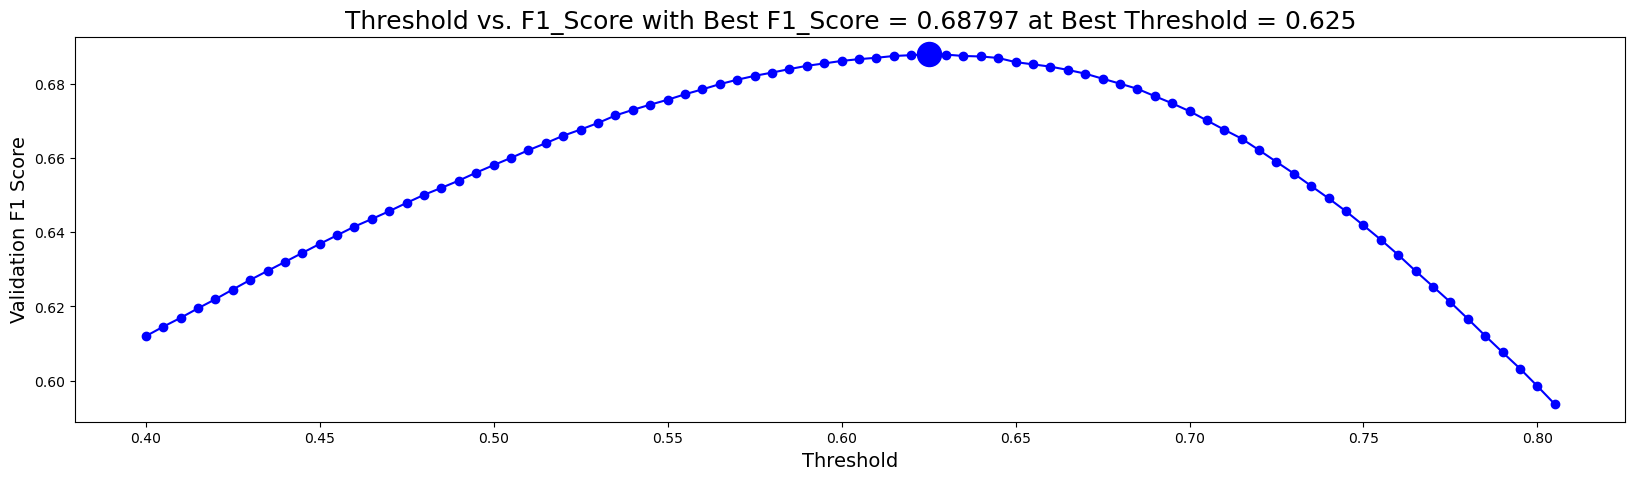

In [14]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    # f1_socre 'macro' 공부
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

Now we use full data to retrain our models with the best iterations, and save them. 

In [15]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')
    
    print()

#########################
### question 1 features 71

#########################
### question 2 features 71

#########################
### question 3 features 71

#########################
### question 4 features 80

#########################
### question 5 features 80

#########################
### question 6 features 80

#########################
### question 7 features 80

#########################
### question 8 features 80

#########################
### question 9 features 80

#########################
### question 10 features 80

#########################
### question 11 features 80

#########################
### question 12 features 80

#########################
### question 13 features 80

#########################
### question 14 features 81

#########################
### question 15 features 81

#########################
### question 16 features 81

#########################
### question 17 features 81

#########################
### question 18 features 81

CPU times: user 18.

We save features names as dict for each questions

In [16]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
# pickle 공부
pickle.dump(importance_dict, f_save)
f_save.close()